In [1]:
import os

from os.path import join as ospj
from os.path import expanduser
from munch import Munch as mch
import numpy as np



from ProbVLM.src.ds import prepare_coco_dataloaders

from ProbVLM.src.networks import *
from ProbVLM.src.train_probVLM import *

import matplotlib.pyplot as plt
from ProbVLM.src.utils import load_data_loader

dataset = 'coco' # coco or flickr

data_dir = ospj('dataset', dataset) # e.g. ospj(expanduser('~'), 'Documents', 'jm', 'data', dataset)
dataloader_config = mch({
    'batch_size': 32,
    'random_erasing_prob': 0.,
    'traindata_shuffle': True
})
from ProbVLM.src.utils import load_data_loader
loaders = load_data_loader(dataset, data_dir, dataloader_config)
coco_train_loader, coco_valid_loader, coco_test_loader = loaders['train'], loaders['val'], loaders['test']



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/Inter-CLIP/Inter-ProbVLM/ProbVLM/src/train_probVLM.py:26: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:83.)
  dtype=torch.cuda.FloatTensor(),


creating index...
index created!
Loading COCO Caption: n_images 113287 n_captions 566435...
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
Loading COCO Caption: n_images 1000 n_captions 5000...
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Loading COCO Caption: n_images 5000 n_captions 25000...


tensor([[49406,   320,   786,  ...,     0,     0,     0],
        [49406,   786,  6765,  ...,     0,     0,     0],
        [49406,   320,   786,  ...,     0,     0,     0],
        ...,
        [49406,   320,  2175,  ...,     0,     0,     0],
        [49406,   320,  8470,  ...,     0,     0,     0],
        [49406,   320,  8470,  ...,     0,     0,     0]])
torch.Size([32, 3, 224, 224])


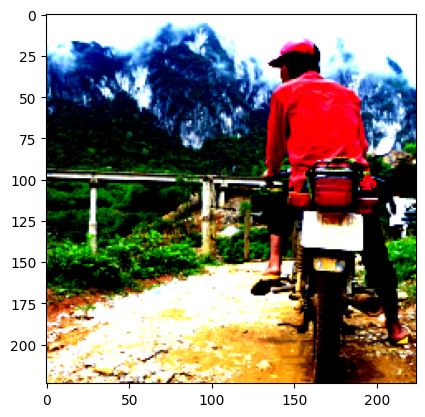

In [2]:
test_data = next(iter(coco_test_loader))
print(test_data[1])

print(test_data[0].shape)

plt.imshow(test_data[0][1].permute(1, 2, 0))
plt.show()

In [3]:
# clip_net = load_model('cuda')
model_name = "ViT-B/32"
CLIP_Net = clip.load(model_name, jit=False)[0].eval().float()

if model_name == "RN50":
    input_dim = 1024
    out_dim = 1024
else:
    input_dim = 512
    out_dim = 512

ProbVLM_Net = BayesCap_for_CLIP(
    inp_dim=input_dim,
    out_dim=out_dim,
    hid_dim=256,
    num_layers=3,
    p_drop=0.05,
)
# load ProbVLM_Net

ProbVLM_Net.load_state_dict(torch.load("models/_last_agent_C.pth"))

<All keys matched successfully>

In [45]:
from utils import *
from ProbVLM.src.losses import *
from sample import *

test_data = next(iter(coco_test_loader))
# test_data = next(iter(coco_train_loader))

image = test_data[0].cuda()
cap = test_data[1].cuda()

print(image.shape)

CLIP_Net.eval()
ProbVLM_Net.eval().cuda()


with torch.no_grad():
    image_emb = CLIP_Net.encode_image(image)
    text_emb = CLIP_Net.encode_text(cap)

mu_cap, alpha_cap, beta_cap = ProbVLM_Net.txt_BayesCap(text_emb)
mu_img, alpha_img, beta_img = ProbVLM_Net.img_BayesCap(image_emb)

print(image_emb[0][:10],mu_img[0][:10])
# alpha_cap = torch.
# s_like(alpha_cap)*10
beta_cap = beta_cap

GGL = GenGaussLoss()


Li_index = 0

for i, Sp_index in enumerate(range(len(mu_cap))):
    p_sp = -GGL(mu_cap[Sp_index], alpha_cap[Sp_index], beta_cap[Sp_index],mu_img[Li_index])
    p_li = -GGL(mu_cap[Li_index], alpha_cap[Li_index], beta_cap[Li_index],mu_img[Li_index])

    print(p_sp, p_li)

    r = np.exp(np.min([0,(p_sp-p_li).item()]))
    print(torch.abs(mu_cap[Sp_index]-mu_img[Li_index]).sum(),torch.abs(mu_cap[Li_index]-mu_img[Li_index]).sum())
    # print(mu_cap[Li_index][:10],mu_img[Li_index][:10])
    # print(alpha_cap[Sp_index].mean(),alpha_cap[Sp_index].min(),alpha_cap[Sp_index].max(),alpha_cap[Sp_index].std())
    # print(beta_cap[Sp_index].mean(),beta_cap[Sp_index].min(),beta_cap[Sp_index].max(),beta_cap[Sp_index].std())
    print(i, r, "\n")

torch.Size([32, 3, 224, 224])
tensor([-0.1328,  0.4783,  0.3627,  0.4391, -0.3341, -0.1554,  0.6576, -0.2508,
        -0.0015,  0.1135], device='cuda:0') tensor([-0.1241,  0.4718,  0.3712,  0.4474, -0.3430, -0.1748,  0.6532, -0.2568,
         0.0053,  0.1290], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(-161.6652, device='cuda:0', grad_fn=<NegBackward0>) tensor(-161.6652, device='cuda:0', grad_fn=<NegBackward0>)
tensor(154.2344, device='cuda:0', grad_fn=<SumBackward0>) tensor(154.2344, device='cuda:0', grad_fn=<SumBackward0>)
0 1.0 

tensor(-184.4232, device='cuda:0', grad_fn=<NegBackward0>) tensor(-161.6652, device='cuda:0', grad_fn=<NegBackward0>)
tensor(157.5427, device='cuda:0', grad_fn=<SumBackward0>) tensor(154.2344, device='cuda:0', grad_fn=<SumBackward0>)
1 1.30723779758654e-10 

tensor(-203.5332, device='cuda:0', grad_fn=<NegBackward0>) tensor(-161.6652, device='cuda:0', grad_fn=<NegBackward0>)
tensor(157.2496, device='cuda:0', grad_fn=<SumBackward0>) tensor(154.2344, de

In [10]:
import torch
import torch.nn as nn
import clip
from CLIP_prefix_caption.train import *
import numpy as np


device = "cuda:0" if torch.cuda.is_available() else "cpu"

prefix_length = 40
prefix_length_clip = 40
prefix_dim = 512
num_layers = 8
mapping_type = "mlp"

model = ClipCaptionPrefix(prefix_length, clip_length=prefix_length_clip, prefix_size=prefix_dim, num_layers=num_layers, mapping_type=mapping_type)
model.load_state_dict(torch.load('models/coco_prefix_latest.pt'))

image_encoder, preprocess = clip.load("ViT-B/32", device=device, jit=False)

data_dir = 'dataset/coco/oscar_split_ViT-B_32_train.pkl'
dataset = ClipCocoDataset(data_dir, prefix_length, normalize_prefix=True)

KeyboardInterrupt: 

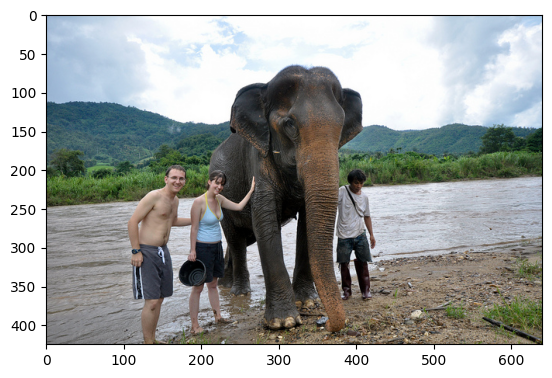

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

People standing near elephants standing on sandy bank.


In [6]:
from utils import *
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt

filename = f"CLIP_prefix_caption/Images/COCO_val2014_000000562207.jpg"
image = io.imread(filename)

plt.imshow(image)
plt.show()

image = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = image_encoder.encode_image(image)


model = model.to(device).float()
prefix_embed = model.clip_project(image_features.float()).reshape(1, prefix_length, -1)
generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
# generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)
print(generated_text_prefix)

In [7]:
from one_agent import OneAgent
agent = OneAgent(agent_name='A')
agent = agent.cuda()
agent.eval()

OneAgent(
  (ProbVLM_Net): BayesCap_for_CLIP(
    (img_BayesCap): BayesCap_MLP(
      (mod): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
        (4): Dropout(p=0.05, inplace=False)
        (5): Linear(in_features=256, out_features=512, bias=True)
      )
      (block_mu): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (block_alpha): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (block_beta): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
      )
    )
    

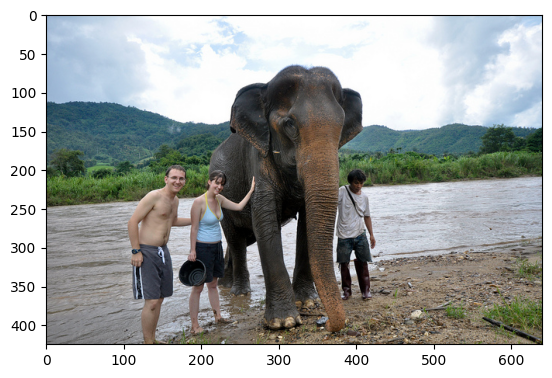

In [8]:
filename = f"CLIP_prefix_caption/Images/COCO_val2014_000000562207.jpg"
image = io.imread(filename)

plt.imshow(image)
plt.show()

image = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)


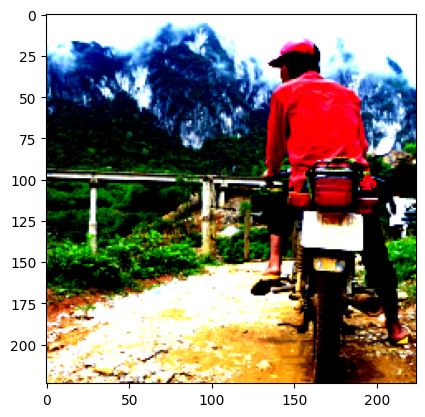

100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

['A person riding a motorbike on a dirt road.', 'a couple of people are riding on a motorcycle   holding their phones   the back of the back of the back of a person riding on a very high level with a person on the side of a bike   with a back view of the street.', 'A young man on a motorcycle stands on top of a mountain.', 'A man riding an  emergency vehicle on a mountain.', 'A man riding a motor bike on the side of a mountain.', 'A motocross man riding on the side of a cliff.', 'a man on a bike riding beside a person on the side of a mountain    walking down a dirt road    riding on a scooter    that is covered by a blanket       with a bag riding on it              ', 'A person on a motorcycle is seen riding it.', 'A motocross rider wears flip-over pants on the side of a mountain.', 'A man riding on a cop motorcycle.']


In [91]:
test_data = next(iter(coco_test_loader))
image = test_data[0][0].cuda()
cap = test_data[1].cuda()

plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.show()

proposed_w_list = []
for i in range(10):
    mu, alpha, beta = agent.image_encoder(image.unsqueeze(0))
    z_li = mu
    proposed_w = agent.text_decoder(z_li)
    proposed_w_list.append(proposed_w)
print(proposed_w_list)

In [96]:
cap_index = 4
mu_li, alpha_li, beta_li = agent.text_encoder(cap[cap_index].unsqueeze(0))

print(cap[cap_index])
print(tokenizer_decode(cap[cap_index]))

proposed_w_list = []
proposed_w_list.append("A man in a red T-shirt is riding a bike on a dirt road.")
proposed_w_list.append("A man in a blue T-shirt is riding a bike on a dirt road.")
proposed_w_list.append("A man in a red T-shirt is riding a bike on an urban street.")
proposed_w_list.append("A person riding a motorbike on a dirt road.")
proposed_w_list.append("A man eating a sandwich in a wooden house.")

beta_weight_list = [1, 0.8, 0.4, 0.1]

for beta_weight in beta_weight_list:
    print(beta_weight)
    print()
    for proposed_w in proposed_w_list:
        print(proposed_w)
        proposed_w = tokenize(proposed_w).cuda()
        mu_sp, alpha_sp, beta_sp = agent.text_encoder(proposed_w)
        weighted_beta_sp = beta_sp * beta_weight
        weighted_beta_li = beta_li * beta_weight
        p_li = -GGL(mu_li, alpha_li, weighted_beta_li, z_li)
        p_sp = -GGL(mu_sp, alpha_sp, weighted_beta_sp, z_li)
        
        # print("mu_li_distance", torch.abs(mu_li-z_li).sum())
        # print("mu_sp_distance", torch.abs(mu_sp-z_li).sum())
        # print("alpha", 1/alpha_sp.mean(), 1/alpha_li.mean())
        # print("beta", beta_sp.mean(), beta_li.mean())
        r = np.exp(np.min([0,(p_sp-p_li).item()]))
        print(r)

tensor([49406,   320,   786,   530,   320,   736,  2523,   537,   320,   736,
         3801,   533,   525,   320, 10297,   525,   320,  2682,  1145,   269,
        49407,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')
a man in a red shirt and a red hat is on a motorcycle on a hill side.
1

A man in a red T-shirt is riding a bike on a dirt road.
1.0
A man in a blue T-shirt is riding a bike on a dirt road.
0.061545463955242595
A man in a red T-shirt is riding a bike on an urban street.
0.15141576275666
A person riding a motorbike on a dirt road.
3.1134399225298914e-05
A man eating a sandwich 